# Fashion MNIST
In this notebook we will classify the images from Fashion MNIST database.
The process goes like:
<ol>
    <li>Data Loading and preprocessing
    <li>Define model
    <li>Train the model
    <li>Model evaluation and predictions

In [275]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Data Loading and preprocessing

In [276]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers=0
batch_size=100
valid_size=0.2

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))])
trainset=datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',download=True,train=True,transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

train_count=len(trainset)
indices=list(range(train_count))
np.random.shuffle(indices)
split=int(np.floor(valid_size*train_count))
train_index,valid_index=indices[:split],indices[split:]

train_sampler=SubsetRandomSampler(train_index)
valid_sampler=SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
    num_workers=num_workers)

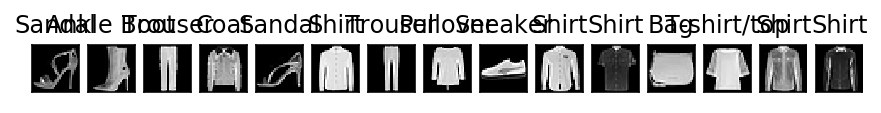

In [277]:
one_batch=iter(train_loader)
images,labels=one_batch.next()
images=images.numpy()
label_list=['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(15):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(label_list[labels[idx].item()]))

## Defining model

In [278]:
from torch import nn,optim
import torch.nn.functional as F

In [279]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv1=nn.Conv2d(1,32,3,1)
        self.conv2=nn.Conv2d(32,64,3,1)

        self.pool=nn.MaxPool2d(2,2)

        self.fc1=nn.Linear(64*5*5,600)
        self.fc2=nn.Linear(600,120)
        self.fc3=nn.Linear(120,10)

        self.dropout=nn.Dropout(0.2)
    
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        
        x=x.view(-1,64*5*5)
        
        x=self.dropout(x)
        
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        
        return x


In [280]:
model=Network()
model

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Training the model

In [281]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [282]:
epochs=25

valid_loss_min=np.inf
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    train_loss=0
    valid_loss=0
    
    model.train()
    for image,label in train_loader:
        optimizer.zero_grad()
        output=model(image)
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()/len(train_loader.sampler)
        
    model.eval()
    for image,label in valid_loader:
        output=model(image)
        loss=criterion(output,label)
        valid_loss+=loss.item()/len(valid_loader.sampler)
        
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print("Epoch: {}\tTraining Loss: {}\tValidation Loss: {}".format(epoch,train_loss,valid_loss))
    
    if valid_loss <= valid_loss_min:
        print("Saving model")
        torch.save(model.state_dict(), 'fashion_mnist_model.pt')
        valid_loss_min = valid_loss

    

Epoch: 0	Training Loss: 0.014724203442533813	Validation Loss: 0.0103527562705179
Saving model
Epoch: 1	Training Loss: 0.00678409785280625	Validation Loss: 0.0044324147915467665
Saving model
Epoch: 2	Training Loss: 0.0043378134767214456	Validation Loss: 0.00401615524540345
Saving model
Epoch: 3	Training Loss: 0.003975927947709956	Validation Loss: 0.0037399293752387146
Saving model
Epoch: 4	Training Loss: 0.0034450171217322344	Validation Loss: 0.0035977125174055484
Saving model
Epoch: 5	Training Loss: 0.00318315960218509	Validation Loss: 0.003403743322317799
Saving model
Epoch: 6	Training Loss: 0.0029220746991535035	Validation Loss: 0.003742133402886488
Epoch: 7	Training Loss: 0.0027701923859616137	Validation Loss: 0.0032214333813947917
Saving model
Epoch: 8	Training Loss: 0.0026209923103451735	Validation Loss: 0.003238973587440945
Epoch: 9	Training Loss: 0.0023659423614541685	Validation Loss: 0.0032194631167997956
Saving model
Epoch: 10	Training Loss: 0.002180745325982571	Validation Los

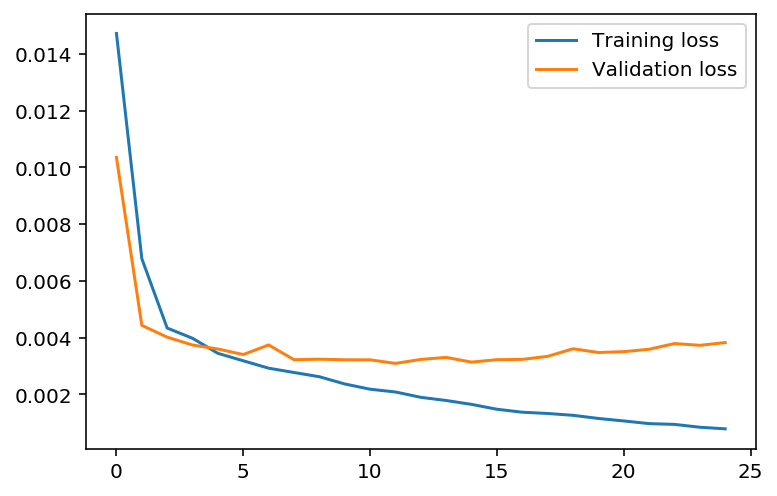

In [288]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

## Loading saved Model

In [289]:
model.load_state_dict(torch.load('fashion_mnist_model.pt'))

<All keys matched successfully>

## Evaluating Model

In [290]:
test_loss=0
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))

model.eval()

for image,target in test_loader:
    output=model(image)
    loss=criterion(output,target)
    test_loss+=loss.item()
    
    _,pred=torch.max(output,1)
    correct=np.squeeze(pred.eq(target.data.view_as(pred)))
    
    for i in range(len(target)):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
    
test_loss = test_loss/len(test_loader.sampler)
print('Average Test Loss: {}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {}%% ({}/{})'.format(
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): {}%% ({}/{})'.format(
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Average Test Loss: 0.0032619674041867255

Test Accuracy of 0: 90.3%% (903.0/1000.0)
Test Accuracy of 1: 97.2%% (972.0/1000.0)
Test Accuracy of 2: 79.4%% (794.0/1000.0)
Test Accuracy of 3: 90.0%% (900.0/1000.0)
Test Accuracy of 4: 85.6%% (856.0/1000.0)
Test Accuracy of 5: 97.1%% (971.0/1000.0)
Test Accuracy of 6: 62.1%% (621.0/1000.0)
Test Accuracy of 7: 95.0%% (950.0/1000.0)
Test Accuracy of 8: 96.3%% (963.0/1000.0)
Test Accuracy of 9: 95.3%% (953.0/1000.0)

Test Accuracy (Overall): 88.83%% (8883.0/10000.0)


## Making predictions

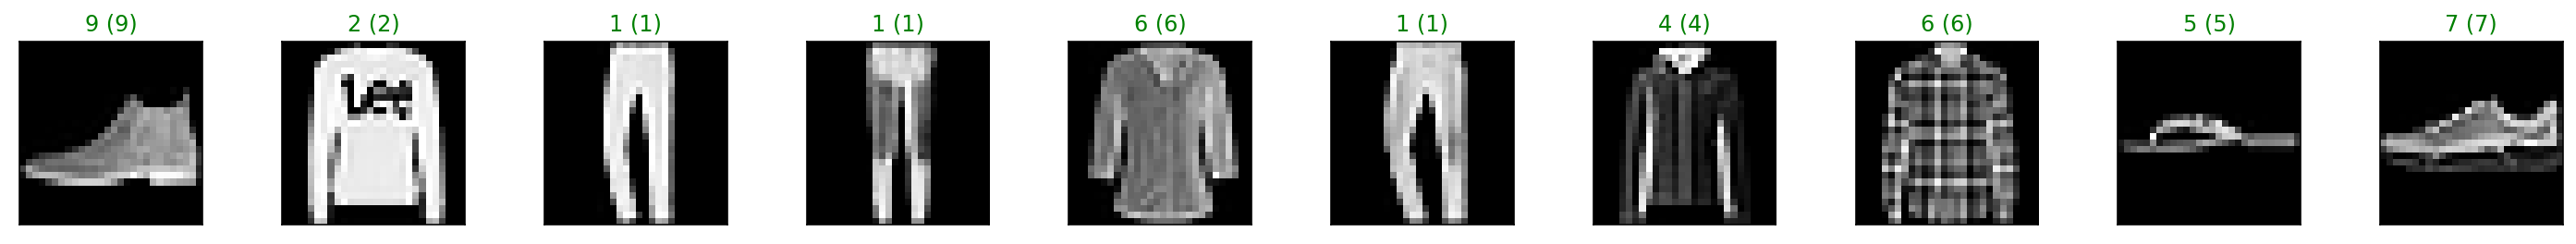

In [293]:
batch=iter(test_loader)
images,labels=batch.next()

output=model(images)
_,preds=torch.max(output,1)
images=images.numpy()

fig=plt.figure(figsize=(25,4))
for index in np.arange(10):
    ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[index]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[index].item()), str(labels[index].item())),color=("green" if preds[index]==labels[index] else "red"))

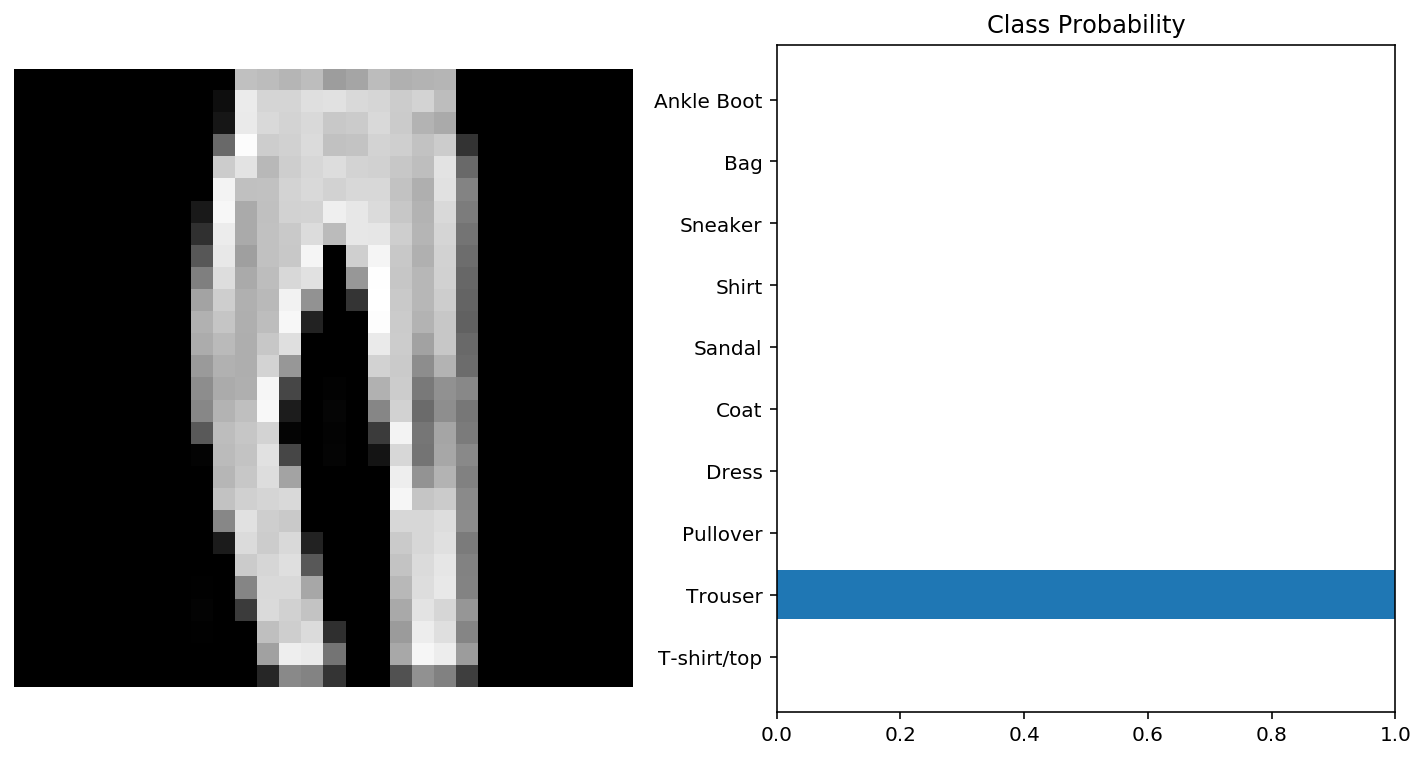

In [300]:
index=5
batch=iter(test_loader)
images,labels=batch.next()
output=model(images)
_,preds=torch.max(output,1)
images=images.numpy()

fig, (ax1, ax2) = plt.subplots(figsize=(10,15), ncols=2)

ax1.imshow(np.squeeze(images[index]), cmap='gray')
ax1.axis('off')

value=(preds[index].item())
bar=np.zeros(10)
bar[value]=1

ax2.barh(np.arange(10),bar)
ax2.set_aspect(0.1)
plt.yticks(np.arange(10),label_list)
ax2.set_title('Class Probability')
ax2.set_xlim(0,1)

plt.tight_layout()